# Compression insights: interpreting the results

After pruning a model, you may want to examine the statistics of the pruned model.  This notebook tries to provide some tools to help you.

We compare a dense ResNet20-Cifar model with a model that was trained using SSL [(Structured Sparsity Learning)](#Wen-et-al-2016), with layer-wise regualrization to remove 5 layers.

## Table of Contents

1. [Load dense and sparse models of your network](#Load-dense-and-sparse-models-of-your-network)
2. [Examine some weights tensor shapes sizes and statistics of the sparse model](#Examine-some-weights-tensor-shapes-sizes-and-statistics-of-the-sparse-model)<br>
    2.1. [View the element-wise sparsity of each layer](#View-the-element-wise-sparsity-of-each-layer)<br>
    2.2. [Compare the sparsity of different weight tensor sub-structures](#Compare-the-sparsity-of-different-weight-tensor-sub-structures)
3. [Compare the distributions of the weight tensors in the sparse and dense models](#Compare-the-distributions-of-the-weight-tensors-in-the-sparse-and-dense-models)
4. [Visualize kernel sparsity](#Visualize-kernel-sparsity)<br>
    4.1. [Fully-connected layers](#Fully-connected-layers)<br>
    4.2. [Convolution layers](#Convolution-layers)<br>
5. [Visualize channel-wise sparsity](#Visualize-channel-wise-sparsity)
6. [Kernel L1-norm distributions](#Kernel-L1-norm-distributions)
7. [Performance metrics](#Performance-metrics)<br>
    7.1. [Compare sparse model compute vs. dense model compute](#Compare-sparse-model-compute-vs.-dense-model-compute)<br>
    7.2. [Now compare dense ResNet20-Cifar to ResNet20-Cifar which has 5 layers removed using SSL](#Now-compare-dense-ResNet20-Cifar-to-ResNet20-Cifar-which-has-5-layers-removed-using-SSL)



In [1]:
import matplotlib 

# Load some common jupyter code
%run distiller_jupyter_helpers.ipynb
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
from models import create_model
from apputils import *

## Load dense and sparse models of your network
We find it useful to compare the dense and sparse models, and understand the differences.

We believe that the accuracy results below can be improved, given that we didn't expend much effort in getting the results below.

|       Model     |  Top1  |  Top5  |  Loss | MACs  | Footprint |
| --------------- | ------ | ------ | ----- | ----- | --------- |
| Baseline        | 91.780 | 99.710 | 0.376 | 100.0%| 100.0%    |
| Channel removal | 91.740 | 99.700 | 0.332 | 73.4% | 91.22%    |
| Layer removal   | 91.020 | 99.670 | 0.349 | 71.1% | 93.20%    |

In [2]:
ckpt_files = {
    'Original': '../../resnet20_cifar_baseline/best.pth.tar',
    'Pruning_filter-wise': '../examples/classifier_compression/logs/2018.11.03-231903/best.pth.tar',
    'Pruning_element-wise': '../examples/classifier_compression/logs/2018.11.03-215240/best.pth.tar'#,
    #'Quantization': '../examples/classifier_compression/logs/2018.11.03-134551/best.pth.tar'
}

model_dict = {
    'Original': create_model(False, 'cifar10', 'resnet20_cifar'),
    'Pruning_filter-wise': create_model(False, 'cifar10', 'resnet20_cifar'),
    'Pruning_element-wise': create_model(False, 'cifar10', 'resnet20_cifar')#,
    #'Quantization': create_model(False, 'cifar10', 'resnet20_cifar')
}

for k in ckpt_files:
    load_checkpoint(model_dict[k], ckpt_files[k]);

In [3]:
models_dict = {'Dense': model_dict['Original'], 'Sparse': model_dict['Pruning_filter-wise']}

## Examine some weights tensor shapes, sizes and statistics of the sparse model

You can extract sparsity information from a model using ```distiller.weights_sparsity_summary```.<br>
The columns with ```(%)``` in their name usually show the fraction of the tensor that is sparse (in percentage), but you can choose to display their density (percentage of non-zero, NNZ, elements). 

In [4]:
def view_data(what, model_choice):
    df_sparsity = distiller.weights_sparsity_summary(models_dict[model_choice])
    # Remove these two columns which contains uninteresting values
    df_sparsity = df_sparsity.drop(['Cols (%)', 'Rows (%)'], axis=1)
    
    if what == 'Density':
        for granularity in ['Fine (%)', 'Ch (%)', '2D (%)', '3D (%)']:
            df_sparsity[granularity] = 100 - df_sparsity[granularity]
    display(df_sparsity)

display_radio = widgets.RadioButtons(options=['Sparsity', 'Density'], value='Sparsity', description='Display:')
model_dropdown = widgets.Dropdown(description='Model:', options=models_dict.keys(), value='Sparse')
interact(view_data, what=display_radio, model_choice=model_dropdown);

interactive(children=(RadioButtons(description='Display:', options=('Sparsity', 'Density'), value='Sparsity'),…

### View the element-wise sparsity of each layer

It is appearant that we removed 5 entire layers, all of which have only a few parameters.  If we wanted to reduce the footprint, then this is not a good choice of layers to remove.  Later on in the notebook we look at the compute metric and see the benefit of removing these layers.

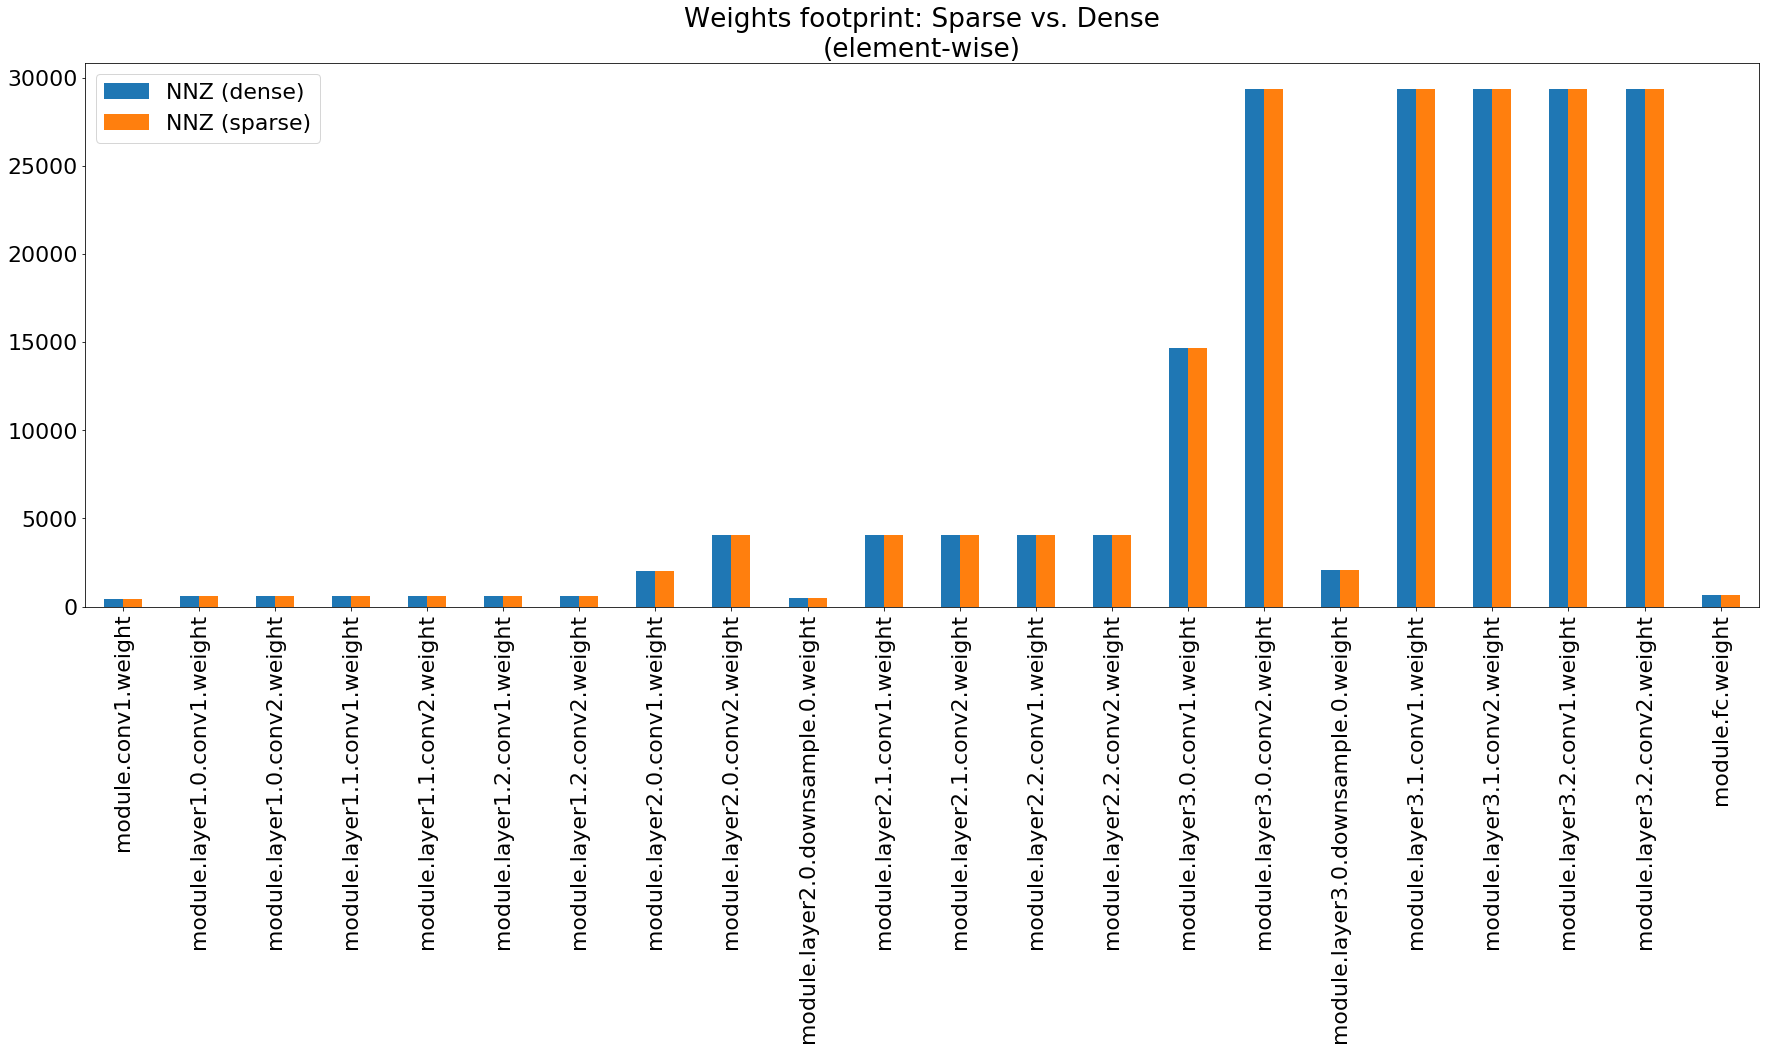

In [5]:
matplotlib.rcParams.update({'font.size': 22})

df_sparsity = distiller.weights_sparsity_summary(models_dict['Sparse'])
df2_sparsity = df_sparsity[['NNZ (dense)', 'NNZ (sparse)']]
ax = df2_sparsity.iloc[0:-1].plot(kind='bar', figsize=[30,10], title="Weights footprint: Sparse vs. Dense\n(element-wise)")
ax.set_xticklabels(df_sparsity.Name, rotation=90);

### Compare the sparsity of different weight tensor sub-structures

Use the widget below to select the different structures who's sparsity you want to compare.<br>
You can choose multiple structures, to compare between them.
Ch (%) - this is the percentage of channels that are sparse<br>
2D (%) - this is the percentage of kernels that are sparse<br>
3D (%) - this is the percentage of filters that are sparse<br>
Fine (%) - this is the percentage of elements that are sparse<br>

In [6]:
def view(cols, what): 
    df_sparsity = distiller.weights_sparsity_summary(models_dict['Sparse'])
    if what == 'Density':
        for granularity in ['Fine (%)', 'Ch (%)', '2D (%)', '3D (%)']:
            df_sparsity[granularity] = 100 - df_sparsity[granularity]
    
    df2 = df_sparsity[list(cols)]
    ax = df2.iloc[0:-1].plot(kind='bar', figsize=[30,10], title="Comparing structural sparsity", grid=True)
    ax.set_ylabel("% Sparsity")
    ax.set_xticklabels(df_sparsity.Name, rotation=90);


items = ['Ch (%)', '2D (%)', '3D (%)', 'Fine (%)']
cols_select = widgets.SelectMultiple(options=items, value=[items[1]])
display_radio = widgets.RadioButtons(options=['Sparsity', 'Density'], value='Sparsity', description='Display:')
interactive(view, cols=cols_select, what=display_radio)

interactive(children=(SelectMultiple(description='cols', index=(1,), options=('Ch (%)', '2D (%)', '3D (%)', 'F…

## Compare the distributions of the weight tensors in the sparse and dense models

We trained the sparse model with layer-wise regularization, but we can see that this affected the distibution of some of the layers.

Look at ```module.layer1.2.conv1.weight``` at an example of a weights tensor that is more "compact" after regularization.

In [7]:
from ipywidgets import *
import bqplot.pyplot as bqplt
from bqplot import Bars, Axis, Figure, LinearScale

xs = LinearScale()
ys = LinearScale()

xs_dense = LinearScale()
ys_dense = LinearScale()

nbins = 100
sparse_tensor = flatten(next (iter (models_dict['Sparse'].state_dict().values())))
sparse_hist, sparse_edges = np.histogram(sparse_tensor, bins=nbins)
sparse_bar = Bars(x=sparse_edges, y=[sparse_hist], scales={'x': xs, 'y': ys}, padding=0.2, type='grouped')


dense_tensor = flatten(next (iter (models_dict['Dense'].state_dict().values())))
dense_hist, dense_edges = np.histogram(dense_tensor, bins=nbins)
dense_bar = Bars(x=dense_edges, y=[dense_hist], scales={'x': xs_dense, 'y': ys_dense}, padding=0.2, type='grouped')

xax = Axis(scale=xs)
yax = Axis(scale=ys, orientation='vertical',  grid_lines='solid')

xax_dense = Axis(scale=xs_dense)
yax_dense = Axis(scale=ys_dense, orientation='vertical', grid_lines='solid')

f = Figure(marks=[sparse_bar], axes=[xax, yax], animation_duration=1000, title="Sparse")
f2 = Figure(marks=[dense_bar], axes=[xax_dense, yax_dense], animation_duration=1000, title="Dense")

shape =  distiller.size2str(next (iter (models_dict['Sparse'].state_dict().values())).size())
param_info = widgets.Text(value=shape, description='shape:', disabled=True)

params_names = conv_fc_param_names(models_dict['Sparse'])

weights_dropdown = Dropdown(description='weights', options=params_names)

def update(*args):
    sparse_model = models_dict['Sparse']
    dense_model = models_dict['Dense']
    
    param_name = weights_dropdown.value
    
    sparse_tensor = flatten(sparse_model.state_dict()[param_name])
    sparse_hist, sparse_edges = np.histogram(sparse_tensor, bins=nbins, density=False)
    sparse_bar.x = sparse_edges
    sparse_bar.y = sparse_hist
    
    dense_tensor = flatten(dense_model.state_dict()[param_name])
    dense_hist, dense_edges = np.histogram(dense_tensor, bins=nbins, density=False)
    dense_bar.x = dense_edges
    dense_bar.y = dense_hist
    shape =  distiller.size2str(dense_model.state_dict()[param_name].size())
    param_info.value = shape

weights_dropdown.observe(update, 'value')

VBox([HBox([weights_dropdown, param_info]), HBox([f, f2])])

## Visualize kernel sparsity

### Fully-connected layers
Classifiers have 2D-shaped weights tensors.

In [8]:
# Color normalization - we want all parameters to share the same color ranges in the kernel plots,
# so we need to find the min and max across all weight tensors in the model.
# As a last step, we also center the colorbar so that 0 is white - this makes it easier to see the sparsity.
extreme_vals = [list((p.max(), p.min())) for param_name, p in models_dict['Sparse'].state_dict().items()  
                if (p.dim()>1) and ("weight" in param_name)]

flat = [item for sublist in extreme_vals for item in sublist]
center = (max(flat) + min(flat)) / 2
sparse_max = max(flat) - center
sparse_min = min(flat) - center

params_names = fc_param_names(models_dict['Sparse'])

def view_weights(pname):
    weights = models_dict['Sparse'].state_dict()[pname]
    aspect_ratio = weights.size(0) / weights.size(1)
    size = 100
    plot_params2d([weights], figsize=(int(size*aspect_ratio),size), binary_mask=False, gmin=sparse_min, gmax=sparse_max);
    

params_dropdown = widgets.Dropdown(description='Weights:', options=params_names, layout=Layout(width='40%'))
interact(view_weights, pname=params_dropdown);

interactive(children=(Dropdown(description='Weights:', layout=Layout(width='40%'), options=('module.fc.weight'…

### Convolution layers

- Choose between the sparse and dense models.
- Colors indicate intensity.
- You can apply a binary mask to distinguish between zero and non-zero elements (zeros are white, everything else is black).

In [9]:
import math 
params_names = conv_param_names(models_dict['Sparse'])

def view_weights(pname, model_choice, apply_mask, color_normalization):
    if model_choice == 'Sparse':
        weights = models_dict['Sparse'].state_dict()[pname]
    else:
        weights = models_dict['Dense'].state_dict()[pname]
    
    num_kernels = weights.size(0) * weights.size(1)
    size = int(min(num_kernels/8, 8))
    
    plot_param_kernels(weights, layout=(size,8), size_ctrl=2, 
                       binary_mask=apply_mask, color_normalization=color_normalization,
                       gmin=sparse_min, gmax=sparse_max);


model_radio = widgets.RadioButtons(options=['Sparse', 'Dense'], value='Sparse', description='Model:')
normalize_radio = widgets.RadioButtons(options=['Group', 'Tensor', 'Model'], value='Model', description='Normalize:')
params_dropdown = widgets.Dropdown(description='Weights:', options=params_names, layout=Layout(width='40%'))
mask_choice = widgets.Checkbox(value=False, description='Binary mask')

interact(view_weights, pname=params_dropdown, 
         model_choice=model_radio, apply_mask=mask_choice,
         color_normalization=normalize_radio);

interactive(children=(Dropdown(description='Weights:', layout=Layout(width='40%'), options=('module.conv1.weig…

## References

<div id="Wen-et-al-2016"></div> **Wei Wen, Chunpeng Wu, Yandan Wang, Yiran Chen, Hai Li**. 
    [*Learning Structured Sparsity in Deep Neural Networks*](https://arxiv.org/abs/1608.03665),
    NIPS 2016.